In [3]:
from power_calculator import calculate_power
import os
import pandas as pd
from scrape_cardlists import DATA_PATH
BASE_PWR_PATH = os.path.join(DATA_PATH, "decks", "baseline")
MANUAL_SAVE = os.path.join(DATA_PATH, "decks", "manual_rand")
GPT_SAVE = os.path.join(DATA_PATH, "completed")
DECKS = os.path.join(DATA_PATH, "decks")

In [47]:
import os
import ast
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compile_power(directory):
    data = []  # To hold dictionaries from files
    for root, dirs, files in os.walk(directory):
        folder_name = os.path.basename(root)  # Get the current folder name
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                #print(file_path)
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()
                    if lines:
                        try:
                            # Convert the last line to a dictionary
                            last_line_dict = ast.literal_eval(lines[-1].strip())
                            # Ensure it's actually a dictionary
                            if isinstance(last_line_dict, dict):
                                last_line_dict['folder'] = folder_name  # Add folder name to the dictionary
                                data.append(last_line_dict)
                        except (ValueError, SyntaxError):
                            print(f"Error processing file: {file_path}")
                            continue
    return pd.DataFrame(data)

# Replace 'path_to_your_directory' with the actual path to your directory
directory_path = 'path_to_your_directory'

df = compile_power(DECKS)
for col in df:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

df.head()

,overall,cmc,ramp,draw,interaction,folder
0,3,3.646154,8,5,12,baseline
1,3,3.415385,5,21,16,baseline
2,8,2.909091,9,15,3,baseline
3,3,3.630769,1,7,8,baseline
4,3,3.636364,1,1,17,baseline


In [50]:
df.groupby('folder').median()

,overall,cmc,ramp,draw,interaction
folder,,,,,
baseline,3.0,3.381818,2.0,7.0,5.0
gpt,6.0,3.234835,9.0,13.0,8.0
manual_rand,5.0,3.179104,5.0,11.0,7.5


In [48]:
df.groupby('folder').mean()

,overall,cmc,ramp,draw,interaction
folder,,,,,
baseline,2.908163,3.353330,4.051020,10.224490,6.683673
gpt,6.010204,3.206208,9.142857,13.530612,8.295918
manual_rand,4.826531,3.183972,5.622449,12.244898,8.673469


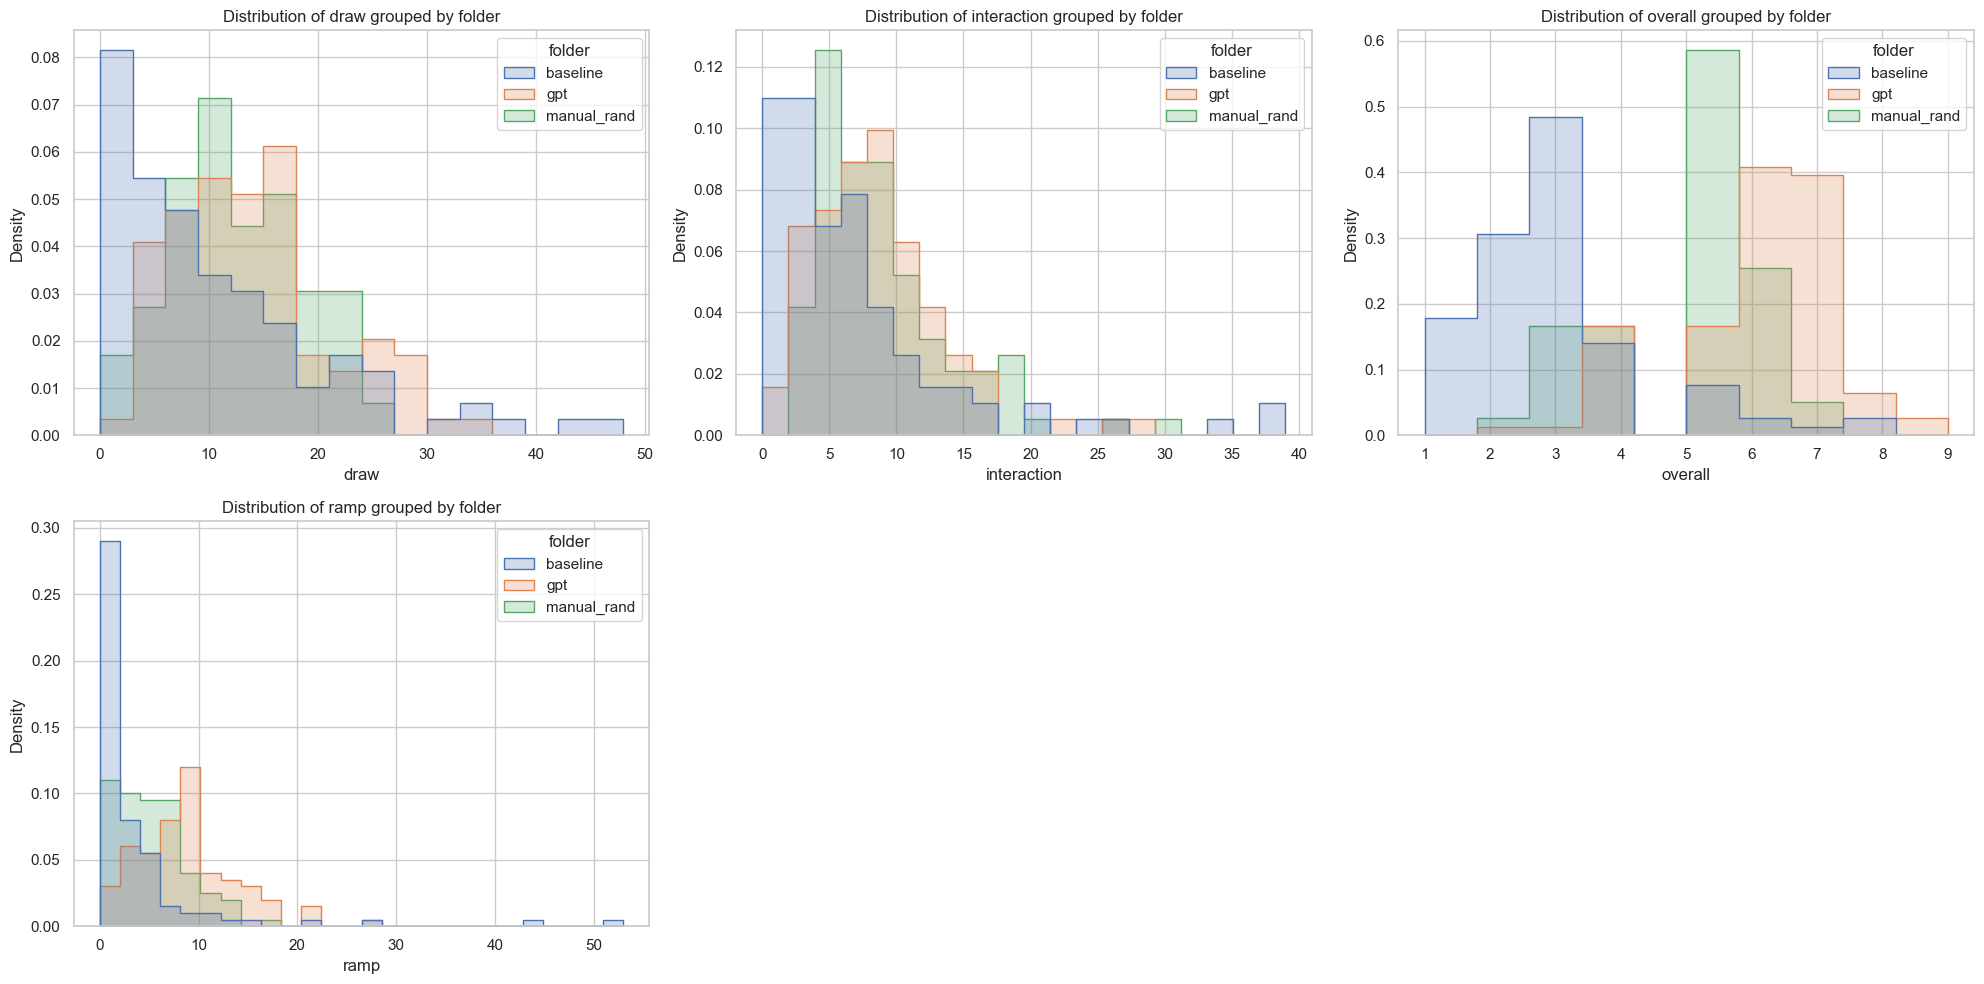

In [49]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))

# Create a column list excluding 'folder'
columns = df.columns.difference(['folder', 'cmc'])

# Plotting
for i, column in enumerate(columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=column, hue="folder", element="step", stat="density", common_norm=False)
    plt.title(f'Distribution of {column} grouped by folder')

plt.tight_layout()
plt.show()

In [46]:
df[df['cmc'] == 0]

,overall,cmc,ramp,draw,interaction,folder
149,1,0.0,0,0,0,gpt


In [61]:
from scipy.stats import f_oneway

for col in df.columns.difference(['folder']):
    # Similar setup as Kruskal-Wallis but for ANOVA
    data = [df[df['folder'] == folder][col] for folder in df['folder'].unique()]

    # Perform ANOVA
    stat, p = f_oneway(*data)

    print(col + ' Statistics= %.3f, p= %.3f' % (stat, p))
    if p > 0.05:
        print('Same means across all groups (fail to reject H0)')
    else:
        print('Different means across some groups (reject H0)')

cmc Statistics= 4.787, p= 0.009
Different means across some groups (reject H0)
draw Statistics= 4.361, p= 0.014
Different means across some groups (reject H0)
interaction Statistics= 2.929, p= 0.055
Same means across all groups (fail to reject H0)
overall Statistics= 147.687, p= 0.000
Different means across some groups (reject H0)
ramp Statistics= 20.365, p= 0.000
Different means across some groups (reject H0)


In [58]:
df.columns.difference(['baseline'])

Index(['cmc', 'draw', 'folder', 'interaction', 'overall', 'ramp'], dtype='object')